In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier  

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)


try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False


class Preprocessing:
    """
    Handles loading, cleaning and exposing X, y.
    """

    def __init__(self, fname: str):
        self.fname = fname
        self._data = pd.read_csv(self.fname)
        self._clean_data = None

    @staticmethod
    def _encode_label(series: pd.Series) -> pd.Series:
        mapping = {
            "non-conductive": 0,
            "conductive": 1,
        }
        return series.map(mapping)

    @property
    def data(self) -> pd.DataFrame:
        return self._data

    @property
    def clean_data(self) -> pd.DataFrame:
        if self._clean_data is None:
            self._clean_data = self._data.dropna().copy()
        return self._clean_data

    @property
    def X(self) -> np.ndarray:
        return self.clean_data.drop(columns=["label"]).to_numpy()

    @property
    def y(self) -> np.ndarray:
        labels = self._encode_label(self.clean_data["label"])
        return labels.to_numpy()


class Classifier:
    def __init__(
        self,
        preprocessor: Preprocessing,
        test_size: float = 0.2,
        random_state: int = 42,
        scale: bool = True,
    ):

        X = preprocessor.X
        y = preprocessor.y
        self.X_full = X           
        self.y_full = y            


        self.feature_names = preprocessor.clean_data.drop(columns=["label"]).columns

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X,
            y,
            test_size=test_size,
            random_state=random_state,
            stratify=y,
        )

        self.scaler = None
        if scale:
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)

        self.models = {}
        self.predictions = {}


    def train_logistic(self, name: str = "logistic", **kwargs) -> float:
        """
        Train a Logistic Regression model and store it.
        Returns test accuracy.
        """
        clf = LogisticRegression(max_iter=1000, **kwargs)
        clf.fit(self.X_train, self.y_train)

        y_pred = clf.predict(self.X_test)
        self.models[name] = clf
        self.predictions[name] = y_pred

        return accuracy_score(self.y_test, y_pred)

    def train_random_forest(self, name: str = "random_forest", **kwargs) -> float:
        """
        Train a Random Forest classifier and store it.
        Returns test accuracy.
        """
        clf = RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            **kwargs,
        )
        clf.fit(self.X_train, self.y_train)

        y_pred = clf.predict(self.X_test)
        self.models[name] = clf
        self.predictions[name] = y_pred

        return accuracy_score(self.y_test, y_pred)

    def train_decision_tree(self, name: str = "decision_tree", **kwargs) -> float:
        """
        Train a single Decision Tree and store it.
        Useful to compare against Random Forest (overfitting vs ensemble).
        """
        clf = DecisionTreeClassifier(random_state=42, **kwargs)
        clf.fit(self.X_train, self.y_train)

        y_pred = clf.predict(self.X_test)
        self.models[name] = clf
        self.predictions[name] = y_pred

        return accuracy_score(self.y_test, y_pred)

    def train_xgboost(self, name: str = "xgboost", **kwargs) -> float:
        """
        Train an XGBoost classifier and store it.
        Returns test accuracy.

        Requires xgboost to be installed.
        """
        if not HAS_XGB:
            raise ImportError("xgboost is not installed. Run: pip install xgboost")

        clf = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            **kwargs,
        )
        clf.fit(self.X_train, self.y_train)

        y_pred = clf.predict(self.X_test)
        self.models[name] = clf
        self.predictions[name] = y_pred

        return accuracy_score(self.y_test, y_pred)


    def cross_validate_logistic(self, cv: int = 5, **kwargs) -> float:
        """
        5-fold cross-validation for Logistic Regression on the full cleaned dataset.
        Returns mean accuracy across folds.
        """
        clf = LogisticRegression(max_iter=1000, **kwargs)
        scores = cross_val_score(clf, self.X_full, self.y_full, cv=cv)
        return scores.mean()

    def logistic_C_sweep(self, C_values=None):
        """
        Evaluate Logistic Regression for a range of C values and plot accuracy vs C.
        Uses the existing train/test split.
        """
        if C_values is None:
            C_values = [0.01, 0.1, 1, 10, 100]

        accuracies = []
        for C in C_values:
            clf = LogisticRegression(max_iter=1000, C=C)
            clf.fit(self.X_train, self.y_train)
            y_pred = clf.predict(self.X_test)
            acc = accuracy_score(self.y_test, y_pred)
            accuracies.append(acc)

        plt.figure(figsize=(6, 4))
        plt.semilogx(C_values, accuracies, marker="o")
        plt.xlabel("C (inverse regularisation strength)")
        plt.ylabel("Accuracy")
        plt.title("Logistic Regression: accuracy vs C")
        plt.grid(True, which="both", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

        return C_values, accuracies


class MetricsAndPlots:
    """
    Computes metrics and creates plots for trained classifiers.
    """

    def __init__(self, clf_pipe: Classifier):
        self.y_test = clf_pipe.y_test
        self.predictions = clf_pipe.predictions
        self.models = clf_pipe.models
        self.X_test = clf_pipe.X_test
        self.feature_names = np.array(clf_pipe.feature_names)
        self.X_full = clf_pipe.X_full     # available if ever needed
        self.y_full = clf_pipe.y_full


    def plot_feature_importance(self, model_name: str, top_n: int | None = None):
        """
        Plot a bar chart of feature importance / weights for a given model.

        For tree models (RandomForest, XGBoost): uses feature_importances_.
        For linear models (LogisticRegression): uses absolute value of coefficients.
        """
        model = self.models[model_name]

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            # LogisticRegression etc. -> use absolute weights
            coef = model.coef_
            importances = np.abs(coef[0])
        else:
            raise ValueError(
                f"Model {model_name} has no feature_importances_ or coef_ attribute."
            )

        importances = np.array(importances)

        # Sort by importance descending
        indices = np.argsort(importances)[::-1]
        if top_n is not None:
            indices = indices[:top_n]

        sorted_importances = importances[indices]
        sorted_features = self.feature_names[indices]

        # Plot
        plt.figure(figsize=(8, 5))
        plt.bar(range(len(sorted_importances)), sorted_importances)
        plt.xticks(
            range(len(sorted_importances)),
            sorted_features,
            rotation=45,
            ha="right",
        )
        plt.ylabel("Importance / weight")
        plt.title(f"Feature importance for {model_name}")
        plt.tight_layout()
        plt.show()


    def basic_metrics(self, model_name: str) -> dict:
        """
        Return accuracy, precision, recall, f1 for a given model.
        """
        y_pred = self.predictions[model_name]

        return {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred),
            "f1": f1_score(self.y_test, y_pred),
        }


    def plot_confusion(self, model_name: str, normalize: bool = False):
        """
        If normalize is True, show proportions instead of counts.
        """
        y_pred = self.predictions[model_name]
        cm = confusion_matrix(self.y_test, y_pred)

        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_title(f"Confusion matrix: {model_name}")
        ax.set_xlabel("Predicted label")
        ax.set_ylabel("True label")
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Non-conductive", "Conductive"], rotation=30, ha="right")
        ax.set_yticklabels(["Non-conductive", "Conductive"])

        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                value = cm[i, j]
                txt = f"{value:.2f}" if normalize else str(value)
                ax.text(
                    j,
                    i,
                    txt,
                    ha="center",
                    va="center",
                    color="white" if value > thresh else "black",
                    fontsize=10,
                )

        plt.tight_layout()
        plt.show()


    def plot_roc(self, model_name: str):
        """
        Plot ROC curve for models that support predict_proba or decision_function.
        """
        model = self.models[model_name]

        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(self.X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(self.X_test)
        else:
            raise ValueError(
                f"Model {model_name} has no probability or decision_function output."
            )

        fpr, tpr, _ = roc_curve(self.y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.legend()
        plt.tight_layout()
        plt.show()


    def compare_models_bar(self, metric: str = "accuracy"):
        """
        Compare models using a chosen metric in a bar chart.
        metric can be: "accuracy", "precision", "recall", "f1"
        """
        metric_func_map = {
            "accuracy": accuracy_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
        }

        if metric not in metric_func_map:
            raise ValueError(f"Unsupported metric: {metric}")

        func = metric_func_map[metric]

        names = []
        values = []

        for name, y_pred in self.predictions.items():
            val = func(self.y_test, y_pred)
            names.append(name)
            values.append(val)

        plt.figure(figsize=(6, 4))
        bars = plt.bar(names, values)

        plt.ylabel(metric.capitalize())
        plt.ylim(0, 1)
        plt.title(f"Model comparison ({metric})")

        # Add value labels on top of bars
        for bar, val in zip(bars, values):
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height() + 0.01,
                f"{val:.2f}",
                ha="center",
                va="bottom",
            )

        plt.tight_layout()
        plt.show()


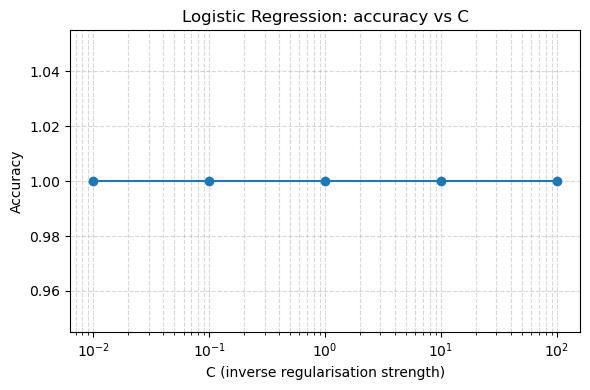

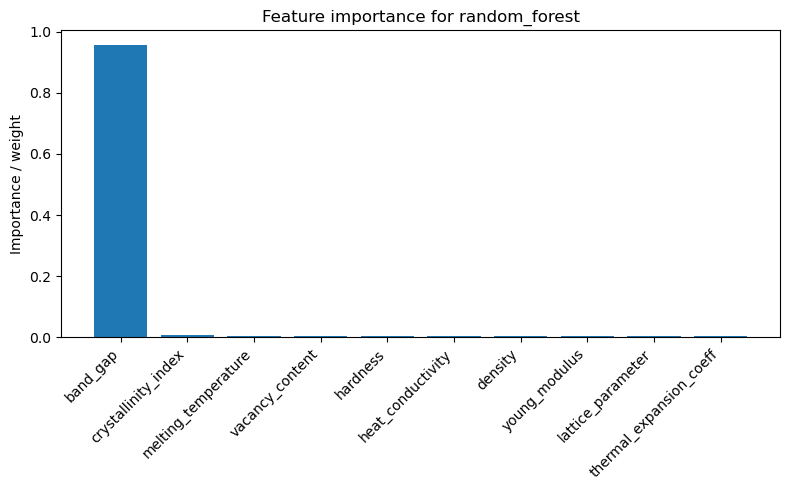

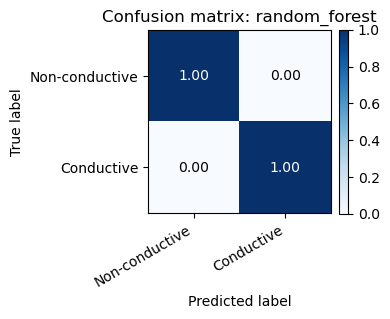

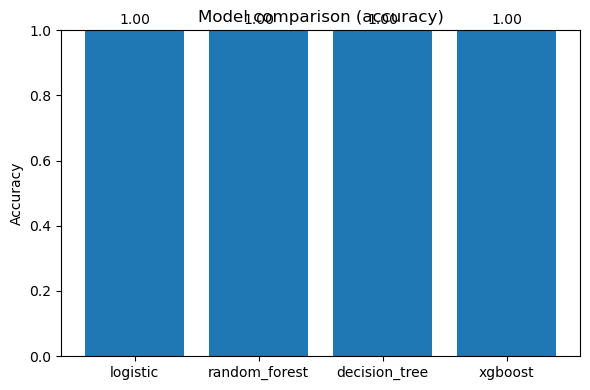

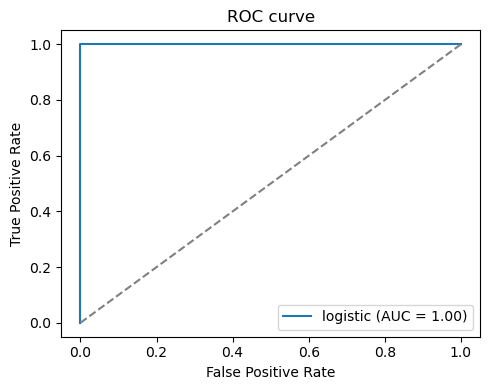

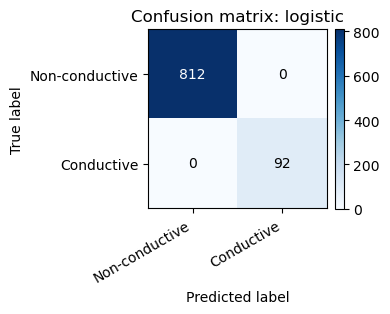

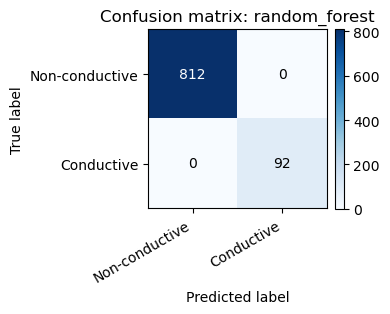

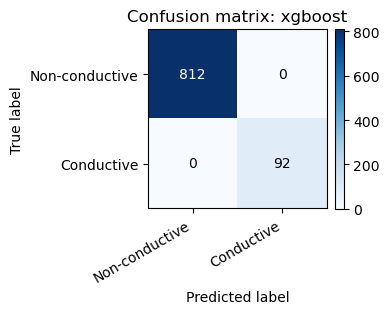

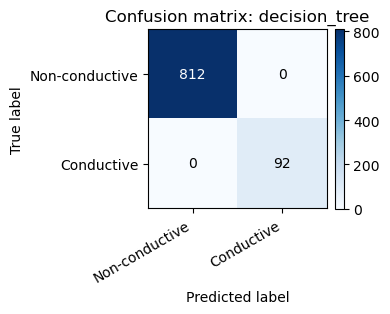

In [8]:
prep = Preprocessing("dataset_1.csv")
clf = Classifier(prep)

# Training models
acc_log = clf.train_logistic()
acc_rf  = clf.train_random_forest()
acc_dt  = clf.train_decision_tree()
acc_xGB = clf.train_xgboost()

# cross validation
cv_log  = clf.cross_validate_logistic(cv=5)
C_vals, C_accs = clf.logistic_C_sweep()

metrics = MetricsAndPlots(clf)
metrics.plot_feature_importance("random_forest")
metrics.compare_models_bar(metric="accuracy")
metrics.plot_roc("logistic")

# Confusion matrices
metrics.plot_confusion("logistic", normalize=False)
metrics.plot_confusion("random_forest", normalize=False)
metrics.plot_confusion("xgboost", normalize=False)
metrics.plot_confusion("decision_tree", normalize=False)